Investigating terrain and forest cover affects on off-nadir GOES-16 ABI surface brightness temperatures in comparison with nadir looking Terra ASTER.

In [28]:
import xarray as xr
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from scipy import stats


Set plot font sizes

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Set up working area geometry

In [3]:
# Larger area around Tuolumne further south and east to include Mammoth
(utm_e_UL, utm_n_UL) = 282500, 4205000
(utm_e_UR, utm_n_UR) = 305000, 4205000
(utm_e_LR, utm_n_LR) = 327500, 4160000
(utm_e_LL, utm_n_LL) = 305000, 4160000

geometry = [
    {
        'type': 'Polygon',
        'coordinates': [[
            [utm_e_UL, utm_n_UL],
            [utm_e_UR, utm_n_UR],
            [utm_e_LR, utm_n_LR],
            [utm_e_LL, utm_n_LL]
        ]]
    }
]

---
---
### Open dataset

In [4]:
_ds = xr.open_dataset('/storage/spestana/ASTER-MODIS-GOES-DEM-FVEG-FSCA_v5_orthorectified.nc')
_ds = _ds.rio.clip(geometry)
sel_these = [x for x in range(27) if (x != 25) & (x != 12)]
ds = _ds.isel(time=sel_these)

---
### modscag

Make two zones based on modscag (threshold at 50%). Then look at ASTER temperatures within each zone, and surface temperature biases (ABI-ASTER) within each zone.

snow 1.1134139174331465 -27.748981766076838 0.9844392788546841 7.141555701163901e-19 0.041441699885951894 2.9957510568520607
open 0.9423738421230413 14.648134665267264 0.994077295735737 1.1213544395531094e-23 0.021481775229177116 1.3179898220023976


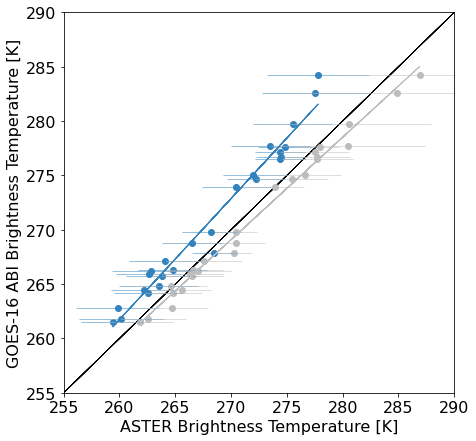

In [45]:
gt_k = [] # greater than threshold, k
lt_k = [] # less than threshold, k
ks = [] # threshold values for each image
times = [] # time of each image

# for each image in the dataset
for i in range(0,len(ds.time)):
    # look at all, or only look at daytime images (daytime hours UTC will be around 18, nighttime around 6)
    if ds.time.isel(time=i).dt.hour > 0:
        ## find the 50% quantile (median) (or some other quantile) and use that as the threshold
        #xx = ds.tcc.values.ravel()
        #xx = xx[~np.isnan(xx)] # remove nans
        #xx = xx[xx!=0] # remove zeros
        k = 50 #np.quantile(xx, 0.50) # median
        times.append(ds.time.isel(time=i).values)
        ks.append(k)
        gt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.modscag > k).isel(time=i).values.ravel())
        lt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.modscag <= k).isel(time=i).values.ravel())

fig, ax = plt.subplots(figsize=(7,7))
m=0

gt_k_n_means = []
lt_k_n_means = []
goes_tb_means = []

for n in range(len(ds.time)):
    
    if True: # for daytime images only # ds.time.isel(time=n).dt.hour.values > 12:
        #print(f'for the {n}th image:')
        
        
        color1='#3182bd'
        color2='#bdbdbd'

        gt_k_n = gt_k[n][~np.isnan(gt_k[n])]
        lt_k_n = lt_k[n][~np.isnan(lt_k[n])]
        
        ax.scatter(np.mean(gt_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color1, edgecolor=None,)
        ax.errorbar(x=np.mean(gt_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(gt_k_n), c=color1, lw=0.5)
        gt_k_n_means.append(np.mean(gt_k_n))
        
        
        ax.scatter(np.mean(lt_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color2, edgecolor=None)
        ax.errorbar(x=np.mean(lt_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(lt_k_n), c=color2, lw=0.5)
        lt_k_n_means.append(np.mean(lt_k_n))
        
        goes_tb_means.append(ds.ast_goes_goes_tb.isel(time=n).mean().values)
        
        plt.xlabel('ASTER Brightness Temperature [K]')
        plt.ylabel('GOES-16 ABI Brightness Temperature [K]')


        plt.ylim(255,290);
        plt.xlim(255,290);
        
        ax.plot([255,290],[255,290],linestyle='-',color='k', lw=0.5, zorder=-99)
        #
        #print('number of pixels: ',len(gt_k_n),len(lt_k_n))
        #print('means: ',np.round(np.mean(gt_k_n),1),np.round(np.mean(lt_k_n),1))
        #print(f'mean diff: {np.round(np.mean(gt_k_n)-np.mean(lt_k_n),1)}')
        #print('medians: ',np.round(np.median(gt_k_n),1),np.round(np.median(lt_k_n),1))
        
        
gt_k_n_means = np.array(gt_k_n_means)
lt_k_n_means = np.array(lt_k_n_means)
goes_tb_means =np.array(goes_tb_means)

gt_slope, gt_intercept, gt_r_value, gt_p_value, gt_std_err = stats.linregress(gt_k_n_means,goes_tb_means)
ax.plot(gt_k_n_means,(gt_k_n_means*gt_slope)+gt_intercept,linestyle='-',color=color1, lw=1)
rmse = np.sqrt(np.mean((gt_k_n_means-goes_tb_means)**2))
print('snow',gt_slope, gt_intercept, gt_r_value, gt_p_value, gt_std_err, rmse)

lt_slope, lt_intercept, lt_r_value, lt_p_value, lt_std_err = stats.linregress(lt_k_n_means,goes_tb_means)
ax.plot(lt_k_n_means,(lt_k_n_means*lt_slope)+lt_intercept,linestyle='-',color=color2, lw=1)
rmse = np.sqrt(np.mean((lt_k_n_means-goes_tb_means)**2))
print('open',lt_slope, lt_intercept, lt_r_value, lt_p_value, lt_std_err,rmse)

---
### Tree Canopy Cover

Make two zones based on TCC, using the median as the threshold between the two groups. Then look at ASTER temperatures within each zone, and surface temperature biases (ABI-ASTER) within each zone.

forest 1.0776151552440836 -21.604308056055004 0.9891620214626167 1.141089550553764e-20 0.03335351135260211 1.2131056800954214
open 1.0183412876036622 -2.894972199549045 0.9905629605870028 2.3387153090640513e-21 0.029380094829023887 2.235818056750338


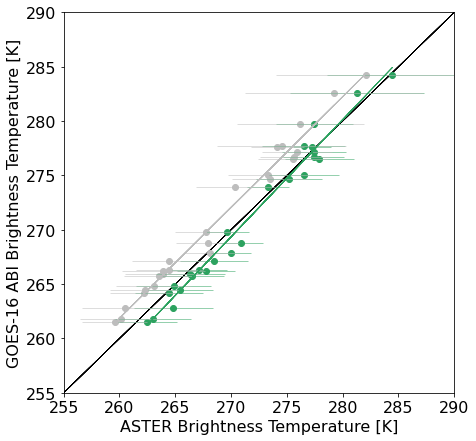

In [46]:
gt_k = [] # greater than threshold, k
lt_k = [] # less than threshold, k
ks = [] # threshold values for each image
times = [] # time of each image

# for each image in the dataset
for i in range(0,len(ds.time)):
    # look at all, or only look at daytime images (daytime hours UTC will be around 18, nighttime around 6)
    if ds.time.isel(time=i).dt.hour > 0:
        ## find the 50% quantile (median) (or some other quantile) and use that as the threshold
        #xx = ds.tcc.values.ravel()
        #xx = xx[~np.isnan(xx)] # remove nans
        #xx = xx[xx!=0] # remove zeros
        k = 0 #np.quantile(xx, 0.50) # median
        times.append(ds.time.isel(time=i).values)
        ks.append(k)
        gt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.tcc > k).isel(time=i).values.ravel())
        lt_k.append(ds.ast_goes_aster_rad2tbK.where(ds.tcc <= k).isel(time=i).values.ravel())

fig, ax = plt.subplots(figsize=(7,7))
m=0

gt_k_n_means = []
lt_k_n_means = []
goes_tb_means = []

for n in range(len(ds.time)):
    
    if True: # for daytime images only # ds.time.isel(time=n).dt.hour.values > 12:
        #print(f'for the {n}th image:')
        
        color1='#2ca25f'
        color2='#bdbdbd'

        gt_k_n = gt_k[n][~np.isnan(gt_k[n])]
        lt_k_n = lt_k[n][~np.isnan(lt_k[n])]
        
        ax.scatter(np.mean(gt_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color1, edgecolor=None,)
        ax.errorbar(x=np.mean(gt_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(gt_k_n), c=color1, lw=0.5)
        gt_k_n_means.append(np.mean(gt_k_n))
        
        
        ax.scatter(np.mean(lt_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color2, edgecolor=None)
        ax.errorbar(x=np.mean(lt_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(lt_k_n), c=color2, lw=0.5)
        lt_k_n_means.append(np.mean(lt_k_n))
        
        goes_tb_means.append(ds.ast_goes_goes_tb.isel(time=n).mean().values)
        
        plt.xlabel('ASTER Brightness Temperature [K]')
        plt.ylabel('GOES-16 ABI Brightness Temperature [K]')

        plt.ylim(255,290);
        plt.xlim(255,290);
        
        ax.plot([255,290],[255,290],linestyle='-',color='k', lw=0.5, zorder=-99)
        #
        #print('number of pixels: ',len(gt_k_n),len(lt_k_n))
        #print('means: ',np.round(np.mean(gt_k_n),1),np.round(np.mean(lt_k_n),1))
        #print(f'mean diff: {np.round(np.mean(gt_k_n)-np.mean(lt_k_n),1)}')
        #print('medians: ',np.round(np.median(gt_k_n),1),np.round(np.median(lt_k_n),1))
        
        

gt_k_n_means = np.array(gt_k_n_means)
lt_k_n_means = np.array(lt_k_n_means)
goes_tb_means =np.array(goes_tb_means)

gt_slope, gt_intercept, gt_r_value, gt_p_value, gt_std_err = stats.linregress(gt_k_n_means,goes_tb_means)
ax.plot(gt_k_n_means,(gt_k_n_means*gt_slope)+gt_intercept,linestyle='-',color=color1, lw=1)
rmse = np.sqrt(np.mean((gt_k_n_means-goes_tb_means)**2))
print('forest',gt_slope, gt_intercept, gt_r_value, gt_p_value, gt_std_err, rmse)

lt_slope, lt_intercept, lt_r_value, lt_p_value, lt_std_err = stats.linregress(lt_k_n_means,goes_tb_means)
ax.plot(lt_k_n_means,(lt_k_n_means*lt_slope)+lt_intercept,linestyle='-',color=color2, lw=1)
rmse = np.sqrt(np.mean((lt_k_n_means-goes_tb_means)**2))
print('open',lt_slope, lt_intercept, lt_r_value, lt_p_value, lt_std_err, rmse)

---

### Combination of Solar- and Satellite-Facing Terrain

In [13]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap


# magenta
color1='#dd1c77'
magenta_cmap = ListedColormap([color1])

# yellow
color2='#feb24c'
yellow_cmap = ListedColormap([color2])

# grey
color3 = '#bdbdbd'
grey_cmap = ListedColormap(['#f0f0f0'])

# blue
color4 = '#2b8cbe'
blue_cmap = ListedColormap([color4])

# black
black_cmap = ListedColormap(['#000000'])




In [14]:
gtsolar_gtsat_k = []
gtsolar_ltsat_k = [] 
ltsolar_ltsat_k = []
ltsolar_gtsat_k = []
occluded_sat_k = []
times = [] # time of each image

# for each image in the dataset
for i in range(0,len(ds.time)):
    # look at all, or only look at daytime images (daytime hours UTC will be around 18, nighttime around 6)
    if ds.time.isel(time=i).dt.hour > 0:
        # find the 50% quantile (median) (or some other quantile) and use that as the threshold
        xx = ds.solar_hillshade.isel(time=i).values.ravel()
        xx = xx[~np.isnan(xx)] # remove nans
        solar_k = np.quantile(xx, 0.50) # median
        xx = ds.sat_hillshade.isel(time=i).values.ravel()
        xx = xx[~np.isnan(xx)] # remove nans
        sat_k = np.quantile(xx, 0.50) # median
        times.append(ds.time.isel(time=i).values)
        gtsolar_gtsat_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade > solar_k).where(ds.sat_hillshade > sat_k).isel(time=i).values.ravel())
        gtsolar_ltsat_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade > solar_k).where((ds.sat_hillshade <= sat_k) & (ds.sat_hillshade > 0)).isel(time=i).values.ravel())
        ltsolar_ltsat_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade <= solar_k).where((ds.sat_hillshade <= sat_k) & (ds.sat_hillshade > 0)).isel(time=i).values.ravel())
        ltsolar_gtsat_k.append(ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade <= solar_k).where(ds.sat_hillshade > sat_k).isel(time=i).values.ravel())
        occluded_sat_k.append(ds.ast_goes_aster_rad2tbK.where(ds.sat_hillshade <= 0).isel(time=i).values.ravel())


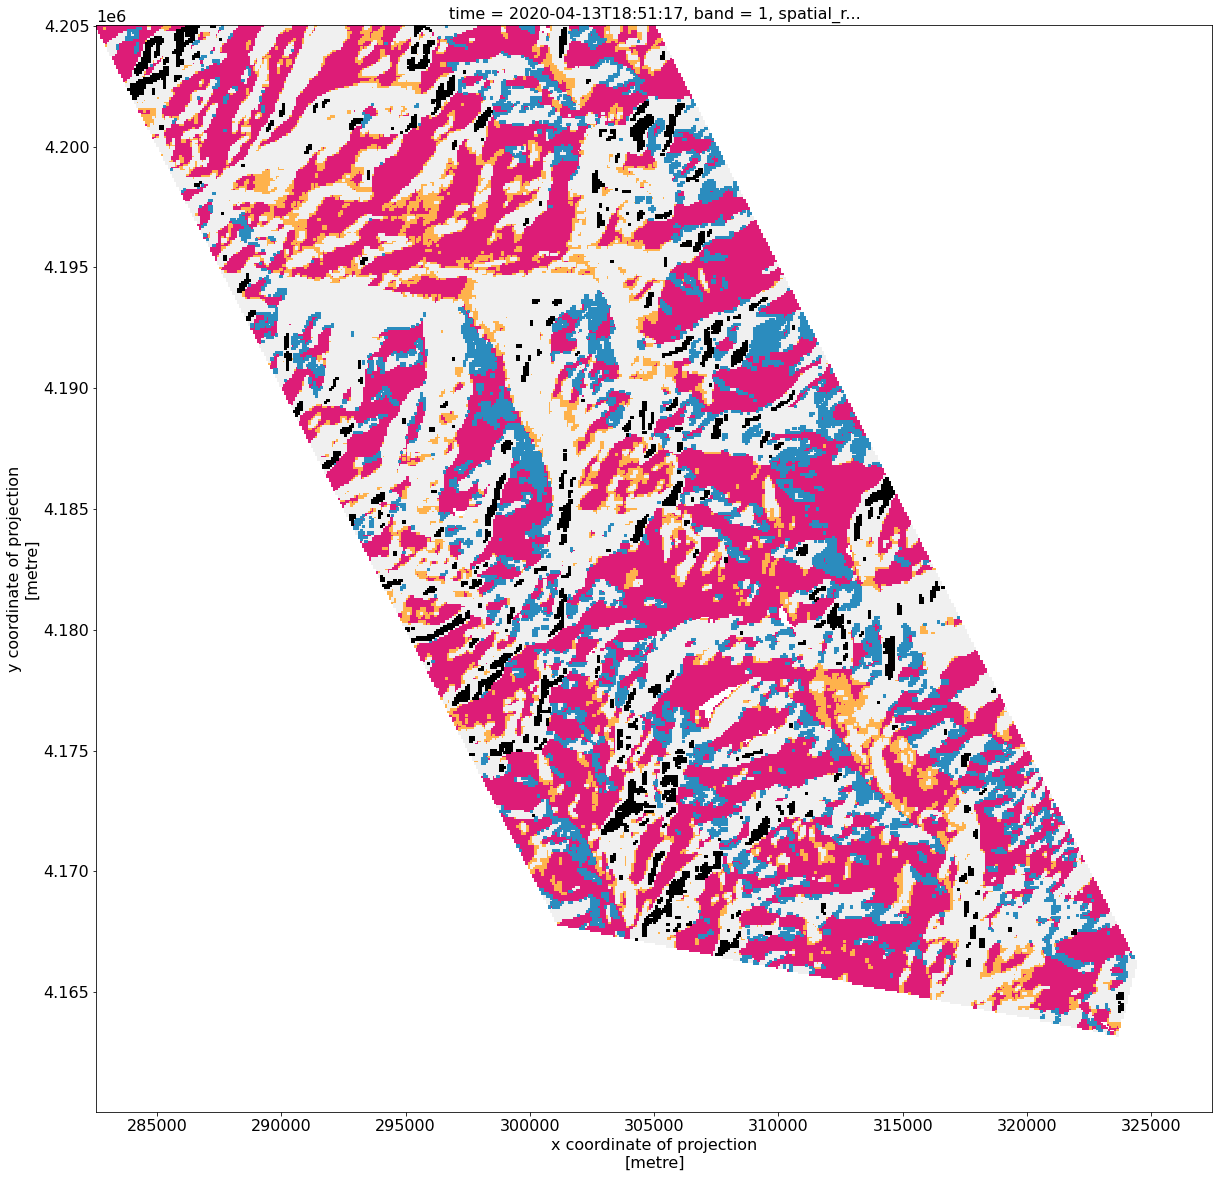

In [15]:
plt.figure(figsize=(20,20))
# magenta
ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade > solar_k).where(ds.sat_hillshade > sat_k).isel(time=i).plot(add_colorbar=False,vmin=500,vmax=501,cmap=magenta_cmap)
# yellow
ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade > solar_k).where(ds.sat_hillshade <= sat_k).isel(time=i).plot(add_colorbar=False,vmin=500,vmax=501,cmap=yellow_cmap)
# blue/purple
ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade <= solar_k).where(ds.sat_hillshade <= sat_k).isel(time=i).plot(add_colorbar=False,vmin=500,vmax=501,cmap=grey_cmap)
# cyan
ds.ast_goes_aster_rad2tbK.where(ds.solar_hillshade <= solar_k).where(ds.sat_hillshade > sat_k).isel(time=i).plot(add_colorbar=False,vmin=500,vmax=501,cmap=blue_cmap)
# black, pixels occluded from satellite's view
ds.ast_goes_aster_rad2tbK.where(ds.sat_hillshade.isel(time=i) <= 0).isel(time=i).plot(cmap='Greys_r',vmin=300,vmax=301, add_colorbar=False)

0.9463593345555391 16.105391252919446 0.9766103551032643 0.00015868990472634606 0.09317986791681337 1.6212924884626632
1.0129541618328517 -1.0457171265725833 0.9711414921651482 0.00026754146018468587 0.11125463592676088 2.748667480080614
1.0524006373044303 -11.039537715588779 0.9915910481081607 1.2397933128074215e-05 0.06142349434345157 3.40909797973492
0.9097889277265246 26.71398011938126 0.9838402124419465 6.320811724452062e-05 0.07404610926850883 2.0293921172722915
0.8136198142519794 55.40046964906202 0.9681534426885893 0.00034171195701491986 0.09409207429002074 4.677057603265985


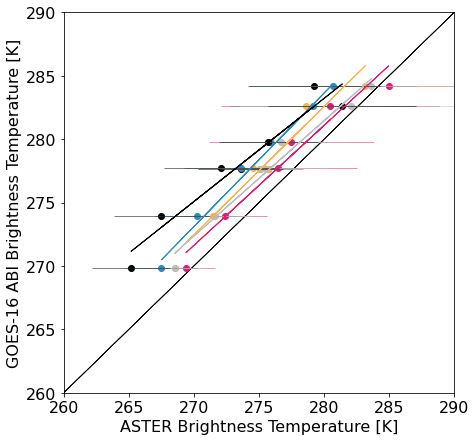

In [44]:

# magenta
color1='#dd1c77'

# yellow
color2='#feb24c'

# blue
color3 = '#2b8cbe'

# grey
color4 = '#bdbdbd'

# black
color5 = '#000000'

gtsolar_gtsat_k_n_means = []
gtsolar_ltsat_k_n_means = []
ltsolar_ltsat_k_n_means = []
ltsolar_gtsat_k_n_means = []
occluded_sat_k_n_means = []
goes_tb_means = []



fig, ax = plt.subplots(figsize=(7,7))
m=0
for n in range(len(ds.time)):
    # for daytime images only # 
    if ds.time.isel(time=n).dt.hour.values > 12:
        #print(f'for the {n}th image:')

        gtsolar_gtsat_k_n = gtsolar_gtsat_k[n][~np.isnan(gtsolar_gtsat_k[n])]
        gtsolar_ltsat_k_n = gtsolar_ltsat_k[n][~np.isnan(gtsolar_ltsat_k[n])]
        ltsolar_ltsat_k_n = ltsolar_ltsat_k[n][~np.isnan(ltsolar_ltsat_k[n])]
        ltsolar_gtsat_k_n = ltsolar_gtsat_k[n][~np.isnan(ltsolar_gtsat_k[n])]
        occluded_sat_k_n = occluded_sat_k[n][~np.isnan(occluded_sat_k[n])]
        
        ax.scatter(np.mean(gtsolar_gtsat_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color1, edgecolor=None,)
        ax.errorbar(x=np.mean(gtsolar_gtsat_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(gtsolar_gtsat_k_n), c=color1, lw=0.5)
        gtsolar_gtsat_k_n_means.append(np.mean(gtsolar_gtsat_k_n))
        
        ax.scatter(np.mean(gtsolar_ltsat_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color2, edgecolor=None)
        ax.errorbar(x=np.mean(gtsolar_ltsat_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(gtsolar_ltsat_k_n), c=color2, lw=0.5)
        gtsolar_ltsat_k_n_means.append(np.mean(gtsolar_ltsat_k_n))
        
        ax.scatter(np.mean(ltsolar_ltsat_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color3, edgecolor=None)
        ax.errorbar(x=np.mean(ltsolar_ltsat_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(ltsolar_ltsat_k_n), c=color3, lw=0.5)
        ltsolar_ltsat_k_n_means.append(np.mean(ltsolar_ltsat_k_n))
        
        ax.scatter(np.mean(ltsolar_gtsat_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color4, edgecolor=None)
        ax.errorbar(x=np.mean(ltsolar_gtsat_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(ltsolar_gtsat_k_n), c=color4, lw=0.5)
        ltsolar_gtsat_k_n_means.append(np.mean(ltsolar_gtsat_k_n))
        
        ax.scatter(np.mean(occluded_sat_k_n),ds.ast_goes_goes_tb.isel(time=n).mean(), c=color5, edgecolor=None)
        ax.errorbar(x=np.mean(occluded_sat_k_n),
                    y=ds.ast_goes_goes_tb.isel(time=n).mean(),
                    xerr=np.std(occluded_sat_k_n), c=color5, lw=0.5)
        occluded_sat_k_n_means.append(np.mean(occluded_sat_k_n))
        
        goes_tb_means.append(ds.ast_goes_goes_tb.isel(time=n).mean().values)
        
        plt.xlabel('ASTER Brightness Temperature [K]')
        plt.ylabel('GOES-16 ABI Brightness Temperature [K]')

        plt.ylim(260,290);
        plt.xlim(260,290);
        
        ax.plot([260,290],[260,290],linestyle='-',color='k', lw=0.5, zorder=-99)
        #
        #print('number of pixels: ',len(gt_k_n),len(lt_k_n))
        #print('means: ',np.round(np.mean(gt_k_n),1),np.round(np.mean(lt_k_n),1))
        #print(f'mean diff: {np.round(np.mean(gt_k_n)-np.mean(lt_k_n),1)}')
        #print('medians: ',np.round(np.median(gt_k_n),1),np.round(np.median(lt_k_n),1))



        
        #print('number of pixels: ',len(gtsolar_gtsat_k_n),len(gtsolar_ltsat_k_n),len(ltsolar_ltsat_k_n),len(ltsolar_gtsat_k_n),len(occluded_sat_k_n))
        #total_px = len(gtsolar_gtsat_k_n)+len(gtsolar_ltsat_k_n)+len(ltsolar_ltsat_k_n)+len(ltsolar_gtsat_k_n)+len(occluded_sat_k_n)
        #print('fraction of area: ',len(gtsolar_gtsat_k_n)/total_px,len(gtsolar_ltsat_k_n)/total_px,len(ltsolar_ltsat_k_n)/total_px,len(ltsolar_gtsat_k_n)/total_px,len(occluded_sat_k_n)/total_px)
        #
        #print('means: ',np.round(np.mean(gtsolar_gtsat_k_n),1),
        #                np.round(np.mean(gtsolar_ltsat_k_n),1),
        #                np.round(np.mean(ltsolar_ltsat_k_n),1),
        #                np.round(np.mean(ltsolar_gtsat_k_n),1),
        #                np.round(np.mean(occluded_sat_k_n),1))
        #
        #print('ASTER image-wide mean: ', np.round(ds.ast_goes_aster_rad2tbK.isel(time=n).mean().values,1))
        #print('MODIS image-wide mean: ', np.round(ds.ast_mod_modis_tb.isel(time=n).mean().values,1))
        #print('GOES-16 ABI image-wide mean: ', np.round(ds.ast_goes_goes_tb.isel(time=n).mean().values,1))
        ##print(f'mean diff: {np.round(np.mean(gt_k_n)-np.mean(lt_k_n),1)}')
        ##print('medians: ',np.round(np.median(gt_k_n),1),np.round(np.median(lt_k_n),1))
        #
        #
        #print(f'Solar LZA: {np.round(ds.solar_lza.isel(time=n).mean().values,0)}, AZI: {np.round(ds.solar_azimuth.isel(time=n).mean().values,0)}')
        #print(f'Satellite LZA: {np.round(ds.sat_lza.isel(time=n).mean().values,0)}, AZI: {np.round(ds.sat_azimuth.isel(time=n).mean().values,0)}')
        
        


gtsolar_gtsat_k_n_means = np.array(gtsolar_gtsat_k_n_means)
gtsolar_ltsat_k_n_means = np.array(gtsolar_ltsat_k_n_means)
ltsolar_ltsat_k_n_means = np.array(ltsolar_ltsat_k_n_means)
ltsolar_gtsat_k_n_means = np.array(ltsolar_gtsat_k_n_means)
occluded_sat_k_n_means = np.array(occluded_sat_k_n_means)
goes_tb_means = np.array(goes_tb_means)

slope, intercept, r_value, p_value, std_err = stats.linregress(gtsolar_gtsat_k_n_means,goes_tb_means)
ax.plot(gtsolar_gtsat_k_n_means,(gtsolar_gtsat_k_n_means*slope)+intercept,linestyle='-',color=color1, lw=1)
rmse = np.sqrt(np.mean((gtsolar_gtsat_k_n_means-goes_tb_means)**2))
print(slope, intercept, r_value, p_value, std_err, rmse)

slope, intercept, r_value, p_value, std_err = stats.linregress(gtsolar_ltsat_k_n_means,goes_tb_means)
ax.plot(gtsolar_ltsat_k_n_means,(gtsolar_ltsat_k_n_means*slope)+intercept,linestyle='-',color=color2, lw=1)
rmse = np.sqrt(np.mean((gtsolar_ltsat_k_n_means-goes_tb_means)**2))
print(slope, intercept, r_value, p_value, std_err, rmse)

slope, intercept, r_value, p_value, std_err = stats.linregress(ltsolar_ltsat_k_n_means,goes_tb_means)
ax.plot(ltsolar_ltsat_k_n_means,(ltsolar_ltsat_k_n_means*slope)+intercept,linestyle='-',color=color3, lw=1)
rmse = np.sqrt(np.mean((ltsolar_ltsat_k_n_means-goes_tb_means)**2))
print(slope, intercept, r_value, p_value, std_err, rmse)


slope, intercept, r_value, p_value, std_err = stats.linregress(ltsolar_gtsat_k_n_means,goes_tb_means)
ax.plot(ltsolar_gtsat_k_n_means,(ltsolar_gtsat_k_n_means*slope)+intercept,linestyle='-',color=color4, lw=1)
rmse = np.sqrt(np.mean((ltsolar_gtsat_k_n_means-goes_tb_means)**2))
print(slope, intercept, r_value, p_value, std_err, rmse)

slope, intercept, r_value, p_value, std_err = stats.linregress(occluded_sat_k_n_means,goes_tb_means)
ax.plot(occluded_sat_k_n_means,(occluded_sat_k_n_means*slope)+intercept,linestyle='-',color=color5, lw=1)
rmse = np.sqrt(np.mean((occluded_sat_k_n_means-goes_tb_means)**2))
print(slope, intercept, r_value, p_value, std_err, rmse)

for the 0th image:
number of pixels:  19766 2327 22341 1184 418
fraction of area:  0.4293596315926666 0.050547397688765316 0.4852941176470588 0.02571900251976714 0.009079850551742114
means:  275.7 275.7 275.1 275.1 273.6
ASTER image-wide mean:  275.4
MODIS image-wide mean:  275.0
GOES-16 ABI image-wide mean:  277.6
Solar LZA: 29.0, AZI: 147.0
Satellite LZA: 54.0, AZI: 137.0
for the 1th image:
number of pixels:  49365 5839 48217 5915 930
fraction of area:  0.4476901311374313 0.05295376634683402 0.4372789436453667 0.05364300872435746 0.008434150146010556
means:  280.5 278.6 279.2 282.1 281.4
ASTER image-wide mean:  279.9
MODIS image-wide mean:  280.1
GOES-16 ABI image-wide mean:  282.6
Solar LZA: 22.0, AZI: 137.0
Satellite LZA: 54.0, AZI: 137.0
for the 5th image:
number of pixels:  18105 2984 14031 4499 1042
fraction of area:  0.4452669634293303 0.07338727527606306 0.3450726740611397 0.1106465655050294 0.02562652172843757
means:  269.4 268.5 267.5 268.6 265.2
ASTER image-wide mean:  268.

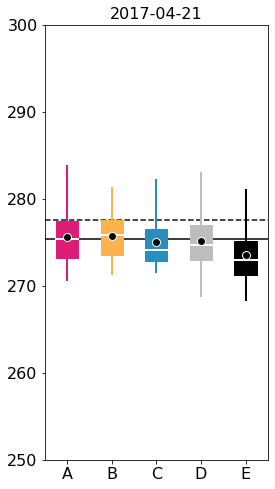

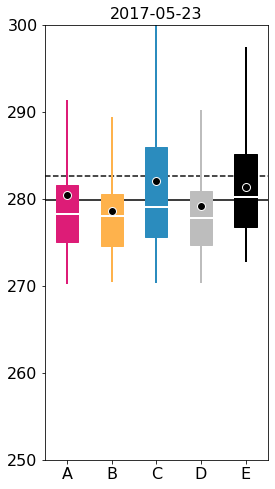

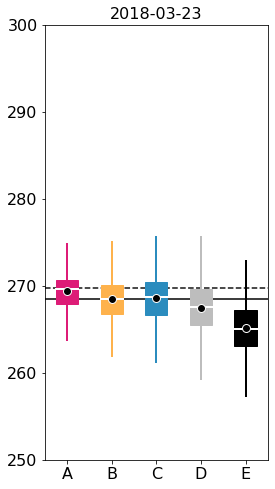

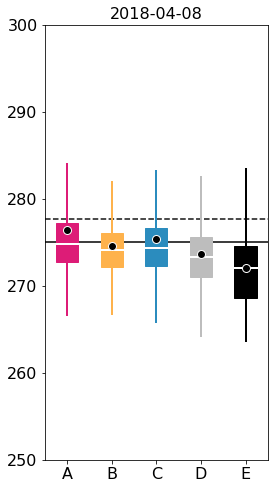

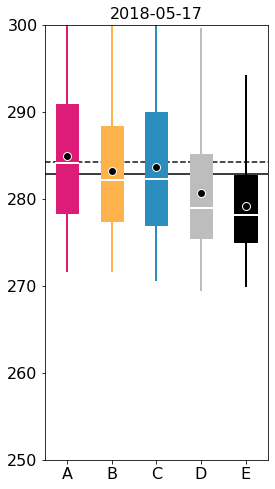

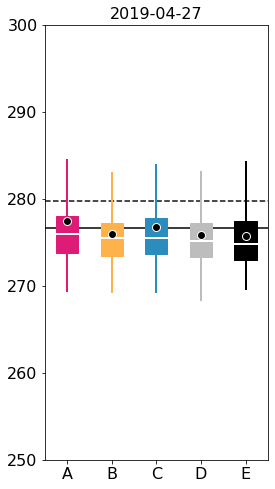

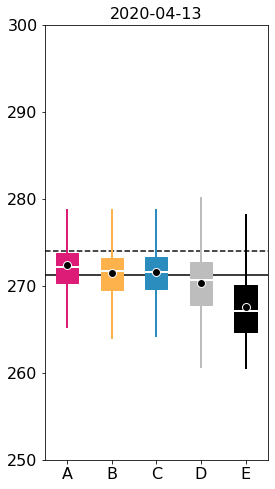

In [11]:

# magenta
color1='#dd1c77'

# yellow
color2='#feb24c'

# blue
color3 = '#2b8cbe'

# grey
color4 = '#bdbdbd'

# black
color5 = '#000000'



for n in range(len(ds.time)):
    # for daytime images only
    if ds.time.isel(time=n).dt.hour.values > 12:
        print(f'for the {n}th image:')
        
        gtsolar_gtsat_k_n = gtsolar_gtsat_k[n][~np.isnan(gtsolar_gtsat_k[n])]
        gtsolar_ltsat_k_n = gtsolar_ltsat_k[n][~np.isnan(gtsolar_ltsat_k[n])]
        ltsolar_ltsat_k_n = ltsolar_ltsat_k[n][~np.isnan(ltsolar_ltsat_k[n])]
        ltsolar_gtsat_k_n = ltsolar_gtsat_k[n][~np.isnan(ltsolar_gtsat_k[n])]
        occluded_sat_k_n = occluded_sat_k[n][~np.isnan(occluded_sat_k[n])]
        
        plt.figure(figsize=(4,8))
        
        bplot = plt.boxplot([gtsolar_gtsat_k_n,
                             gtsolar_ltsat_k_n,
                             ltsolar_gtsat_k_n,
                             ltsolar_ltsat_k_n,
                             occluded_sat_k_n],
                             showfliers=False, showmeans=True, patch_artist=True,
                             labels=['A', 'B', 'C', 'D', 'E']);
        
        
        # fill with colors
        colors = [color1, color2, color3, color4, color5]
        for patch, color in zip(bplot['boxes'], colors):
            patch.set_edgecolor(color)
            patch.set_facecolor(color)
        colors = ['w', 'w', 'w', 'w', 'w']
        for patch, color in zip(bplot['medians'], colors):
            patch.set_color(color)
            patch.set_linewidth(2)
        for patch, color in zip(bplot['means'], colors):
            patch.set_markeredgecolor(color)
            patch.set_markerfacecolor('k')
            patch.set_marker('o')
            patch.set_markersize(8)
        for patch, color in zip(bplot['fliers'], colors):
            patch.set_markeredgecolor(color)
            patch.set_markersize(1)
            patch.set_marker('.')
        colors = [color1, color1, color2, color2, color3, color3, color4, color4, color5, color5]
        for patch, color in zip(bplot['whiskers'], colors):
            patch.set_color(color)
            patch.set_linewidth(2)
        for patch, color in zip(bplot['caps'], colors):
            patch.set_color(color)
            patch.set_linewidth(0)
            
            
            
        plt.title(str(times[n])[:10])
        plt.ylim(250,300);
        
        # horizontal line for mean aster Tb
        plt.axhline(ds.ast_goes_aster_rad2tbK.isel(time=n).mean(), linestyle='-', color='k', zorder=-99)
        
        # horizontal line for mean ABI Tb
        plt.axhline(ds.ast_goes_goes_tb.isel(time=n).mean(), linestyle='--', color='#111111', zorder=-99)
        
        print('number of pixels: ',len(gtsolar_gtsat_k_n),len(gtsolar_ltsat_k_n),len(ltsolar_ltsat_k_n),len(ltsolar_gtsat_k_n),len(occluded_sat_k_n))
        total_px = len(gtsolar_gtsat_k_n)+len(gtsolar_ltsat_k_n)+len(ltsolar_ltsat_k_n)+len(ltsolar_gtsat_k_n)+len(occluded_sat_k_n)
        print('fraction of area: ',len(gtsolar_gtsat_k_n)/total_px,len(gtsolar_ltsat_k_n)/total_px,len(ltsolar_ltsat_k_n)/total_px,len(ltsolar_gtsat_k_n)/total_px,len(occluded_sat_k_n)/total_px)
        
        print('means: ',np.round(np.mean(gtsolar_gtsat_k_n),1),
                        np.round(np.mean(gtsolar_ltsat_k_n),1),
                        np.round(np.mean(ltsolar_ltsat_k_n),1),
                        np.round(np.mean(ltsolar_gtsat_k_n),1),
                        np.round(np.mean(occluded_sat_k_n),1))
        
        print('ASTER image-wide mean: ', np.round(ds.ast_goes_aster_rad2tbK.isel(time=n).mean().values,1))
        print('MODIS image-wide mean: ', np.round(ds.ast_mod_modis_tb.isel(time=n).mean().values,1))
        print('GOES-16 ABI image-wide mean: ', np.round(ds.ast_goes_goes_tb.isel(time=n).mean().values,1))
        #print(f'mean diff: {np.round(np.mean(gt_k_n)-np.mean(lt_k_n),1)}')
        #print('medians: ',np.round(np.median(gt_k_n),1),np.round(np.median(lt_k_n),1))
        
        
        print(f'Solar LZA: {np.round(ds.solar_lza.isel(time=n).mean().values,0)}, AZI: {np.round(ds.solar_azimuth.isel(time=n).mean().values,0)}')
        print(f'Satellite LZA: {np.round(ds.sat_lza.isel(time=n).mean().values,0)}, AZI: {np.round(ds.sat_azimuth.isel(time=n).mean().values,0)}')

---
